### General Information
The dataset was sourced from [here](https://www.kaggle.com/datasets/oscarm524/demand-forecast-for-optimized-inventory-planning?select=orders.csv) and is part of the Data Mining Cup from 2020. It contains real anonymized retail data, encompassing over 2 million item transactions across several months. Additional variables from an extra dataset expand the number of features related to the transacted items, including information such as manufacturer, brand, and user ratings. The main objective of this task is to forecast the number of items that a retail store will require in the next 14 days (e.g., item 455 will require 89 units) based on historical data patterns.

This notebook presents the Exploratory Data Analysis (EDA) phase of the project. Files have been loaded into DataFrames, with a sample of the 2 million orders, to make computations more manageable. During this EDA, the primary goal is to avoid running a separate model for each item (almost 2000 in this sample) and to identify demand patterns that can be leveraged for grouping different items when it comes to forecasting, reducing the number of necessary models. The alternative approach is to utilize a machine learning model with nearly 2000 outputs or a multi-output regression model that produces specific values per 'class' or item. Items in this analysis have been grouped by days, and all graphs are presented with this level of granularity.

### Usefulness
Stock forecasting is a ubiquitous component of supply chain processes. Supermarkets, warehouses, and other entities involved in retailing require accurate predictions of future item demand based on historical data patterns.

### Dataset Information
Features utilized across the three datasets:

itemID: A unique identifier for each item.
simulationPrice: The price of the items during forecasting.
promotion: Dates when different items will be promoted.
brand: The brand of items, categorizing them into 275 different categories.
manufacturer: The manufacturer of the items, categorizing them into 253 different categories.
customerRating: Ratings provided by clients, ranging from 0.0 to 5.0.
category1: A non-specified category to which the item belongs, ranging from 1 to 8.
category2: A non-specified category to which the item belongs, ranging from 1 to 52.
category3: A non-specified category to which the item belongs, ranging from 1 to 8.
recommendedRetailPrice: The recommended price for the item.
time: The timestamp of when the transaction occurred, including year-month-day and hour-minute-seconds.
order: The number of items sold per transaction.


Hope you enjoy it! Any feedback is welcome at borjadaguerre@gmail.com.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Data is structured into a sigle cell in the excel files, can't be loaded directly: load the excel files into DataFrames
# using the 'readlines()' method

with open ('DemandForecast\infos.csv') as data:
    lines = data.readlines()
    lines = [i.strip().split('|') for i in lines]
    data_info = pd.DataFrame(columns = [str(i) for i in lines[0] ] )

    for idx, item in enumerate(lines[1:]):
        data_info.loc[idx, 'itemID'] = item[0]
        data_info.loc[idx, 'simulationPrice'] = item[1]
        data_info.loc[idx,'promotion'] = item[2]
        
data_info
        
    

,itemID,simulationPrice,promotion
0,1,3.43,
1,2,9.15,
2,3,14.04,
3,4,14.1,
4,5,7.48,
...,...,...,...
10458,10459,14.71,
10459,10460,325.67,
10460,10461,190.53,
10461,10462,304.3,


In [5]:
with open ('DemandForecast\items.csv') as data:
    lines = data.readlines()
    lines = [i.strip().split('|') for i in lines]
    data_items = pd.DataFrame(columns = [str(i) for i in lines[0] ] )

    for idx, item in enumerate(lines[1:]):
        data_items.loc[idx, data_items.columns[0]] = item[0]
        data_items.loc[idx, data_items.columns[1]] = item[1]
        data_items.loc[idx,data_items.columns[2]] = item[2]
        data_items.loc[idx,data_items.columns[3]] = item[3]
        data_items.loc[idx,data_items.columns[4]] = item[4]
        data_items.loc[idx,data_items.columns[5]] = item[5]
        data_items.loc[idx,data_items.columns[6]] = item[6]
        data_items.loc[idx,data_items.columns[7]] = item[7]
        
        
data_items

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.0,1,2,1,16.92
2,3,0,3,5.0,1,3,1,15.89
3,4,0,2,4.44,1,2,1,40.17
4,5,0,2,2.33,1,1,1,17.04
...,...,...,...,...,...,...,...,...
10458,10459,180,253,0.0,8,44,8,56.57
10459,10460,0,253,0.0,8,44,8,163.81
10460,10461,0,253,0.0,8,44,8,128.01
10461,10462,180,253,0.0,8,44,8,166.97


In [6]:
with open ('DemandForecast\orders.csv') as data:
    lines = data.readlines()
    lines = [i.strip().split('|') for i in lines]
    data_orders = pd.DataFrame(columns = [str(i) for i in lines[0] ] )

    for idx, item in enumerate(lines[1:]):
        if idx < 100000:
            data_orders.loc[idx, data_orders.columns[0]] = item[0]
            data_orders.loc[idx, data_orders.columns[1]] = item[1]
            data_orders.loc[idx,data_orders.columns[2]] = item[2]
            data_orders.loc[idx,data_orders.columns[3]] = item[3]
            data_orders.loc[idx,data_orders.columns[4]] = item[4]

        else:
            break
        
data_orders

,time,transactID,itemID,order,salesPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47
3,2018-01-01 00:09:24,2278968,450,1,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19
...,...,...,...,...,...
99995,2018-01-18 20:14:00,98418,677,1,32.67
99996,2018-01-18 20:14:00,98417,677,1,32.67
99997,2018-01-18 20:14:01,98421,677,1,32.67
99998,2018-01-18 20:14:01,98420,677,1,32.67


In [8]:
# Add the columns we need for the time series, convert it to suitable formats, extract the dates alone to work with day 
# intervals instead of minutes/seconds

data_items['simulationPrice'] = data_info['simulationPrice']
data_items['promotion'] = data_info['promotion']
data_orders['time'] = pd.to_datetime(data_orders['time'])
data_orders['date'] = [date for date in data_orders['time'].dt.date]
data_orders['order'] = data_orders['order'].astype(int)

In [ ]:
# Total number of items sold in the 100,000 orders(items can be purchased more than once per transaccion)

data_orders['order'].sum()

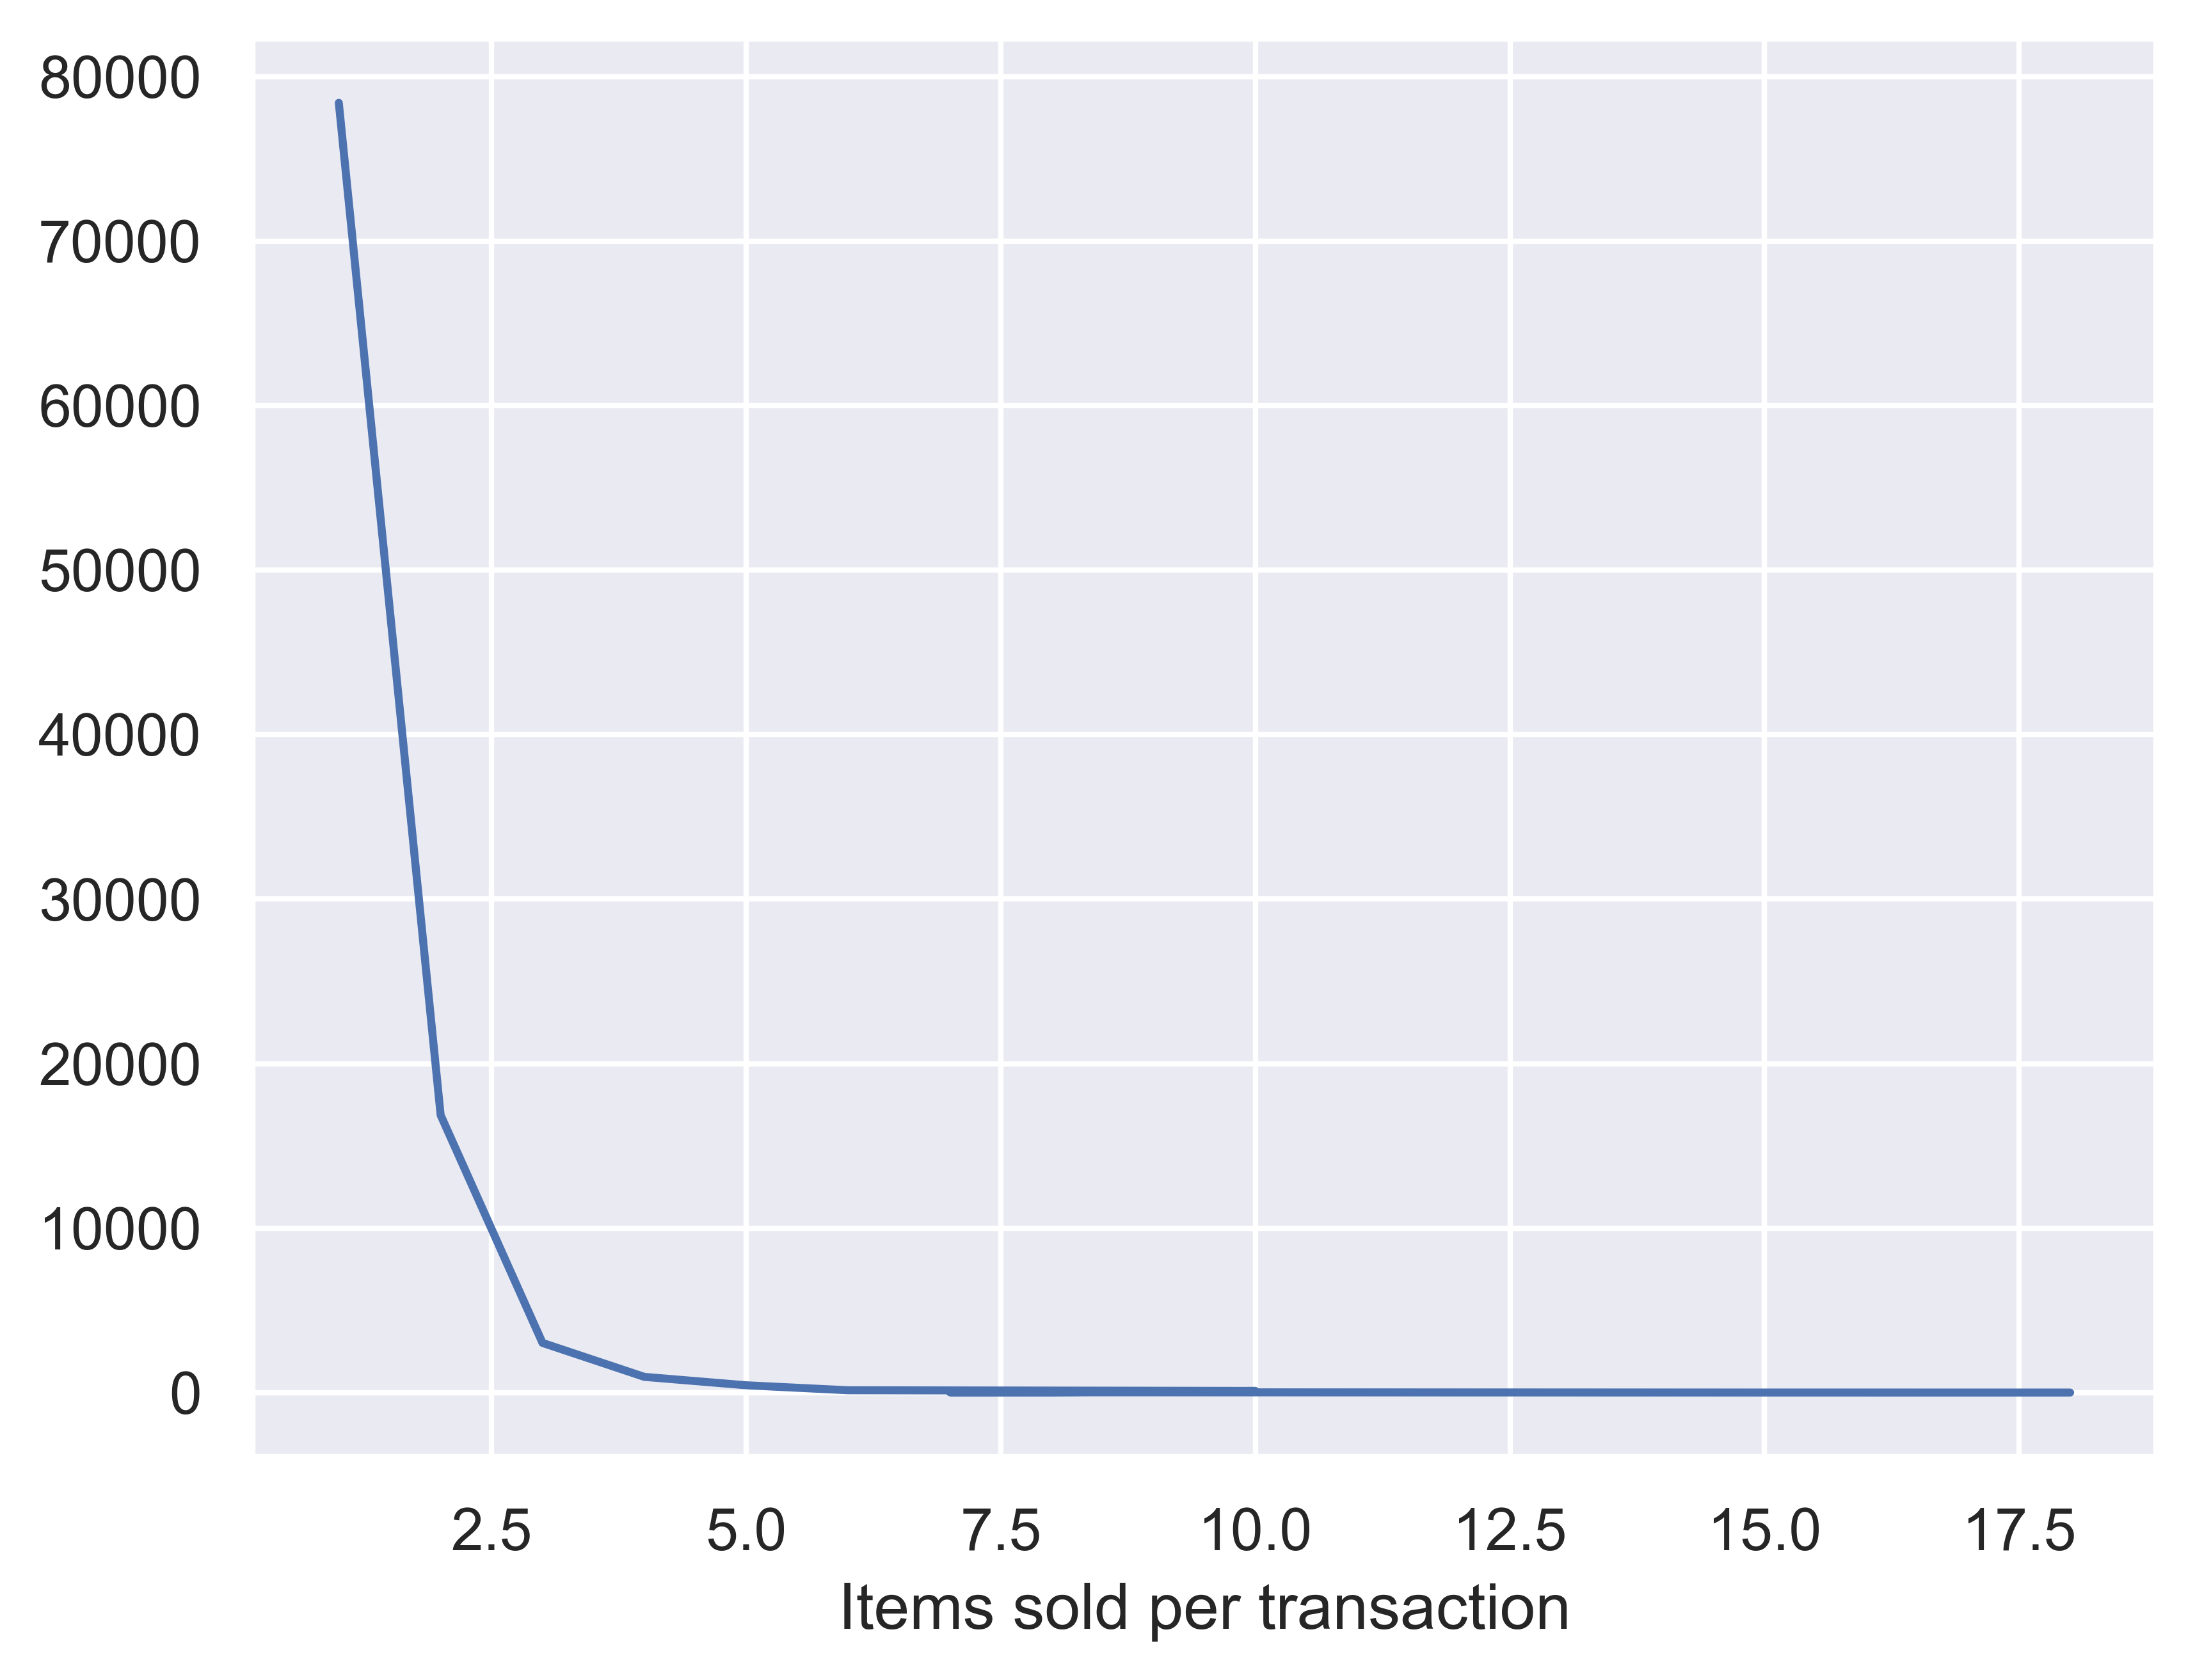

In [22]:
# Plotting the distribution of the items' frequency per transaction

plt.plot(data_orders['order'].value_counts())
plt.xlabel('Items sold per transaction')
plt.show()


In [68]:
# Check the usefulness of the 'customer' ratings, most of them have a value of '0.0'

data_items['customerRating'].value_counts()

0.0     7117
5.0     2080
4.0      301
3.0      186
4.5      116
        ... 
4.85       1
3.26       1
4.36       1
4.72       1
3.88       1
Name: customerRating, Length: 99, dtype: int64

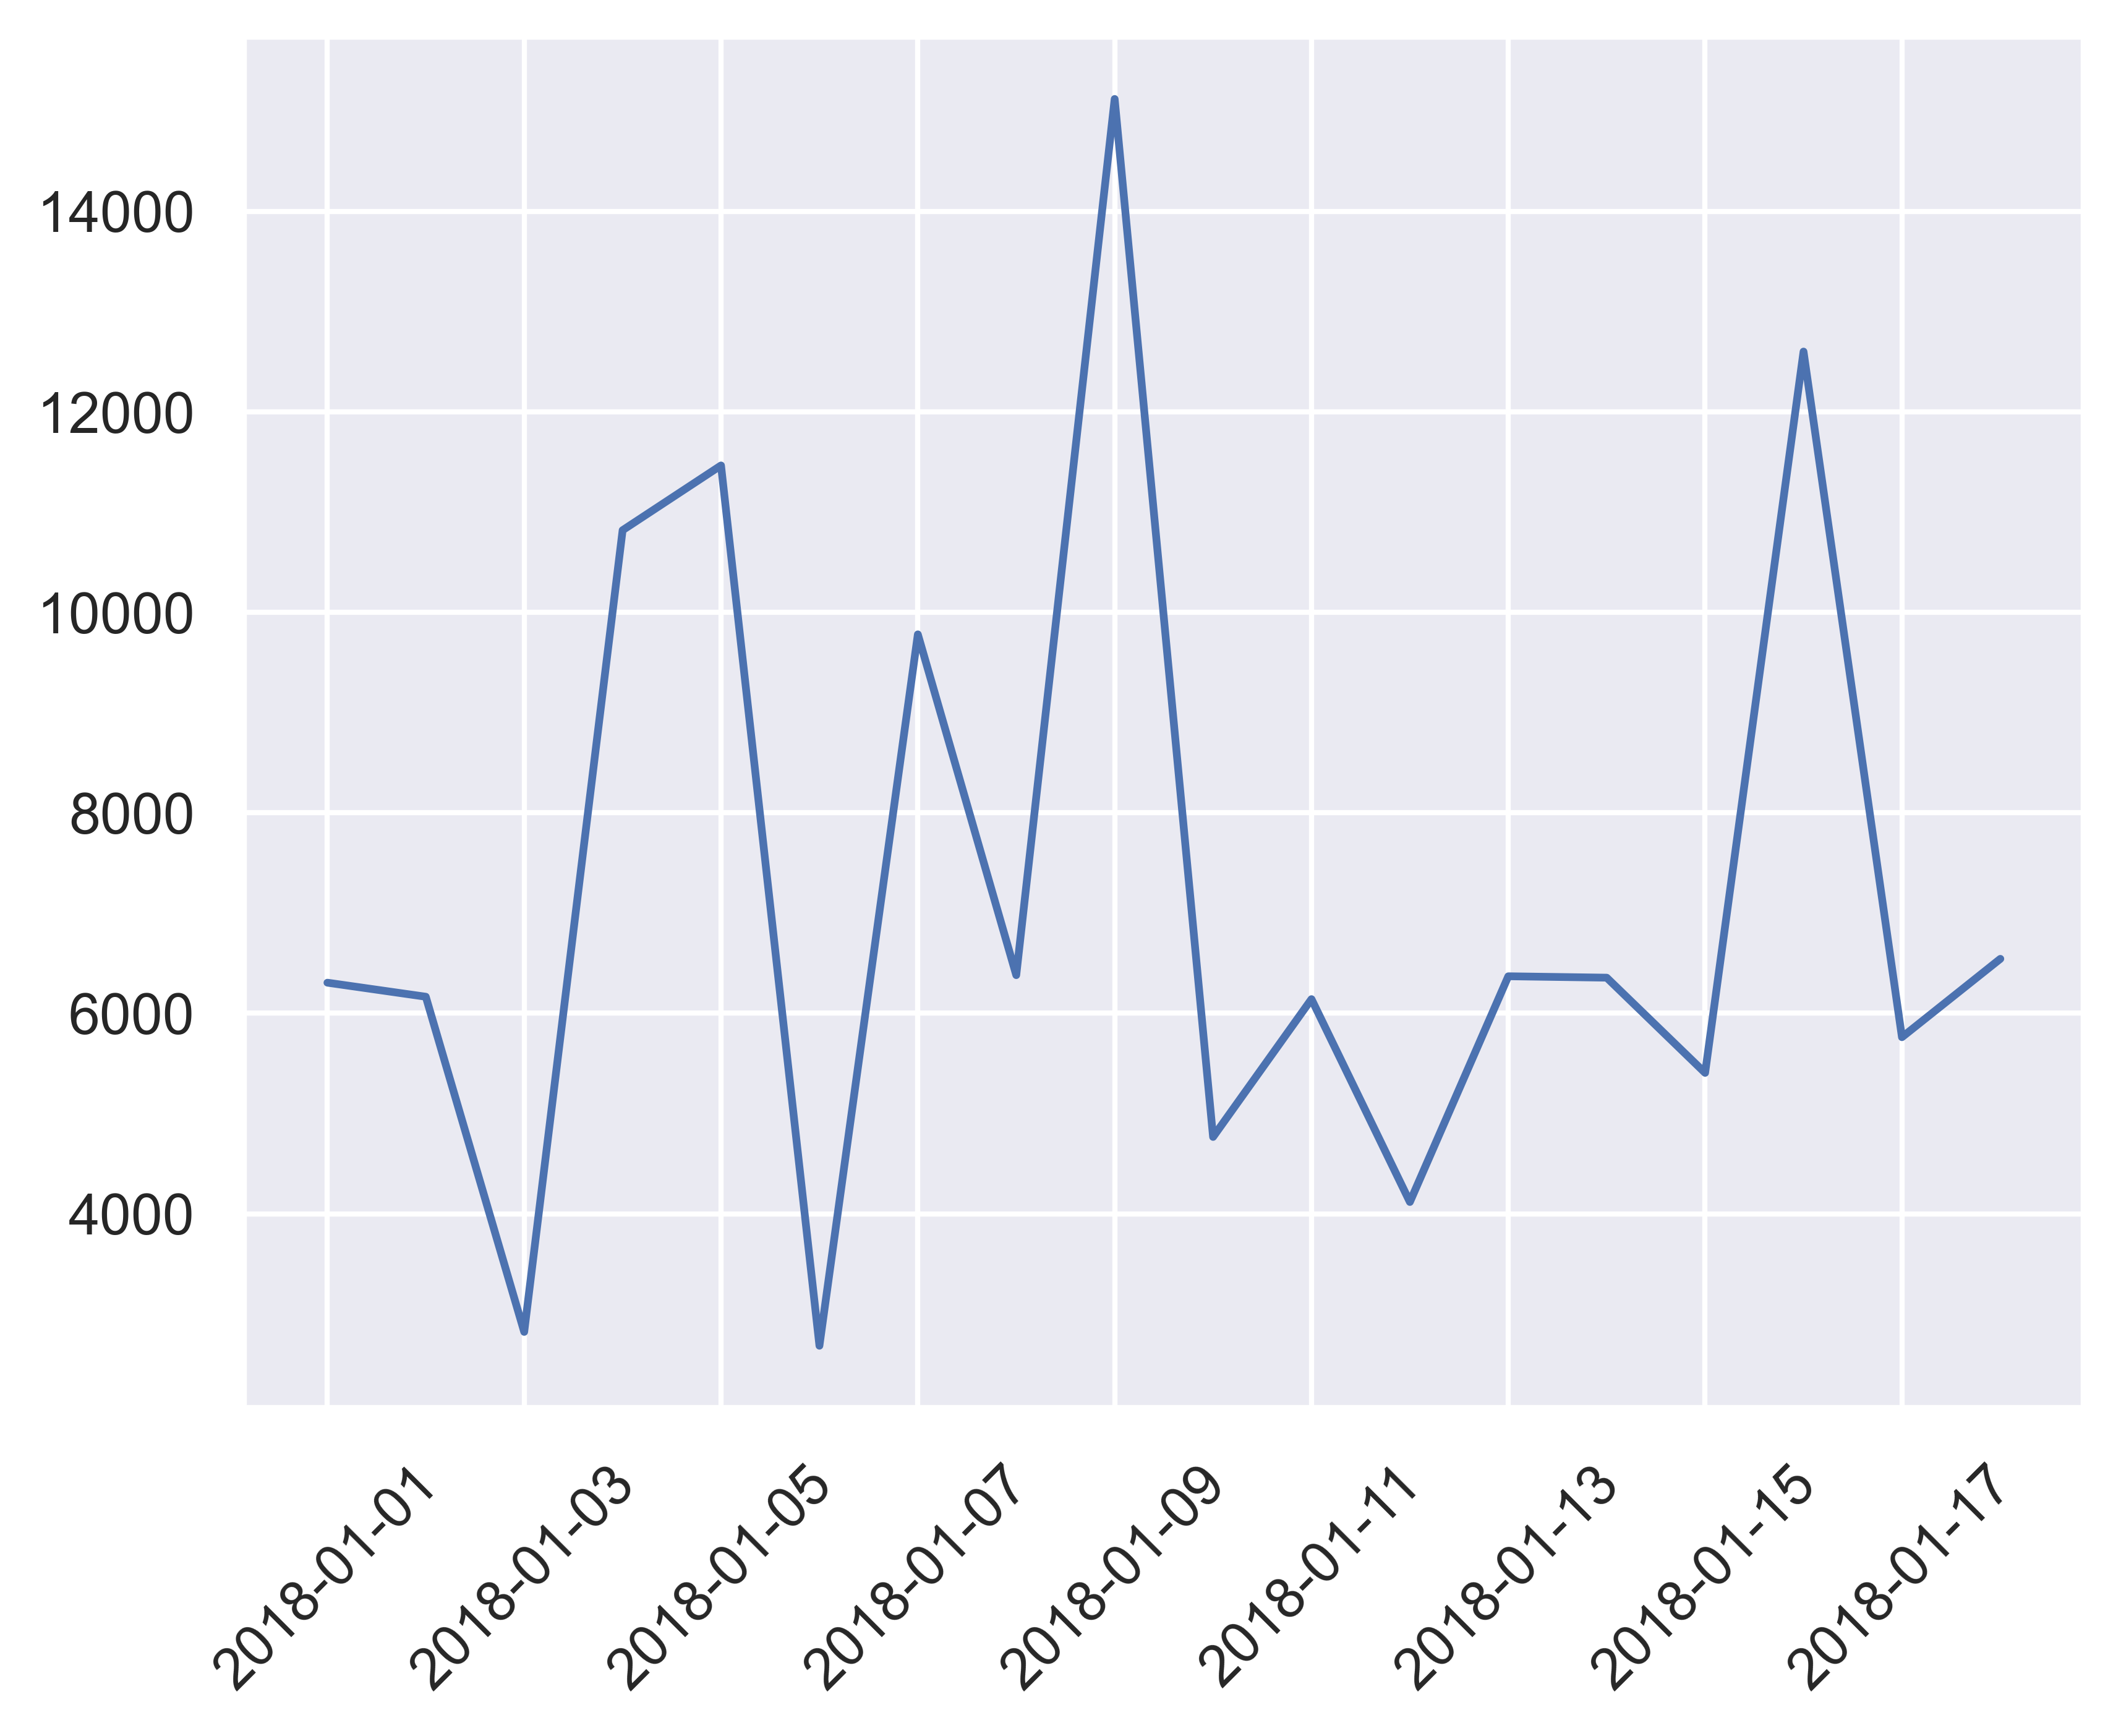

In [17]:
# Plot the total number of items sold per day over time

daily_ord = data_orders.groupby(['date']).agg({'order':'sum'})
plt.plot(daily_ord)
plt.xticks(rotation = 45);
plt.grid(True)

In [9]:
# some SQL-type method to merge the two dataframes where matches are found based on the 'itemID' feature


daily_ordersID = data_orders.groupby(['date', 'itemID']).sum().reset_index()
daily_ordersID.columns = ['date', 'itemID', 'itemsSold']
daily_ordersID = daily_ordersID.merge(data_items, on='itemID', how='left')
daily_ordersID.set_index('date',inplace = True)

daily_ordersID

,itemID,itemsSold,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,simulationPrice,promotion
date,,,,,,,,,,,
2018-01-01,109,2,0,1,5.0,1,1,1,11.83,5.8,
2018-01-01,11,1,0,2,4.88,1,2,1,9.22,2.13,
2018-01-01,113,81,0,8,0.0,1,1,1,7.85,3.71,
2018-01-01,128,1,0,16,5.0,1,4,1,25.96,42.38,
2018-01-01,137,1,0,16,5.0,1,1,1,28.86,42.26,
...,...,...,...,...,...,...,...,...,...,...,...
2018-01-18,9366,1,229,250,3.0,8,44,8,193.37,360.43,
2018-01-18,9393,1,212,246,5.0,8,44,8,153.86,375.65,
2018-01-18,9522,1,230,246,0.0,8,44,8,320.0,35.89,


In [64]:
# Check the number of different items that will need to be forecasted

daily_ordersID['itemID'].value_counts()

7798    18
4481    17
7761    15
4208    15
4962    15
        ..
538      1
586      1
6584     1
6654     1
9613     1
Name: itemID, Length: 1845, dtype: int64

In [140]:
# Check the dates loaded so far into the dataframe

daily_ordersID.index.unique()

Index([2018-01-01, 2018-01-02, 2018-01-03, 2018-01-04, 2018-01-05, 2018-01-06,
       2018-01-07, 2018-01-08, 2018-01-09, 2018-01-10, 2018-01-11, 2018-01-12,
       2018-01-13, 2018-01-14, 2018-01-15, 2018-01-16, 2018-01-17, 2018-01-18],
      dtype='object', name='date')

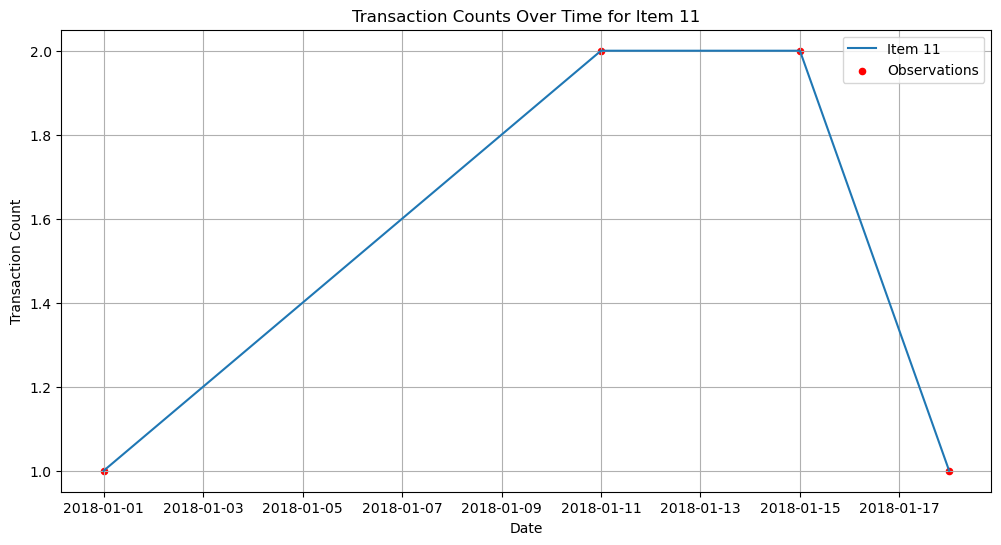

In [190]:
# Time series of a single item

item_id_to_plot = '11'
filtered_df = daily_ordersID[daily_ordersID['itemID'] == item_id_to_plot]

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(filtered_df.index, filtered_df['transactionCount'], label=f'Item {item_id_to_plot}', linestyle='-')
plt.scatter(filtered_df.index, filtered_df['transactionCount'], color='red', marker='o', s=20, label='Observations')
plt.title(f'Transaction Counts Over Time for Item {item_id_to_plot}')
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.legend()
plt.grid(True)
plt.show()


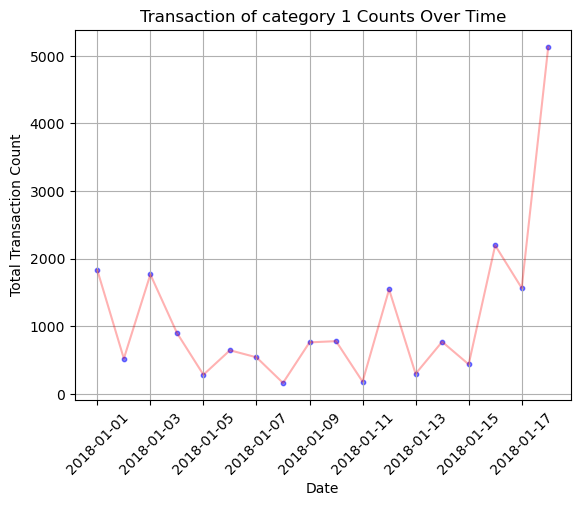

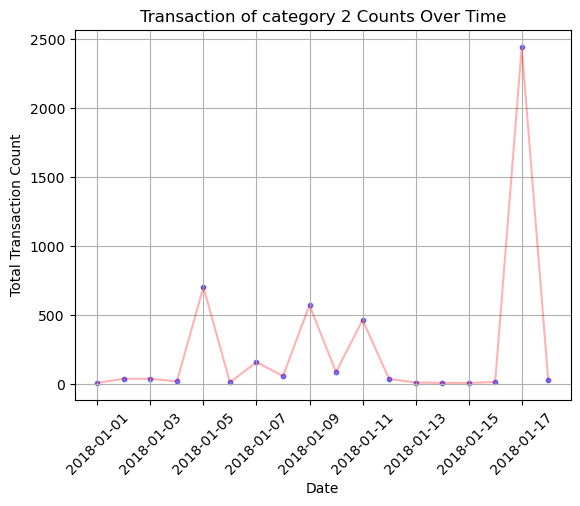

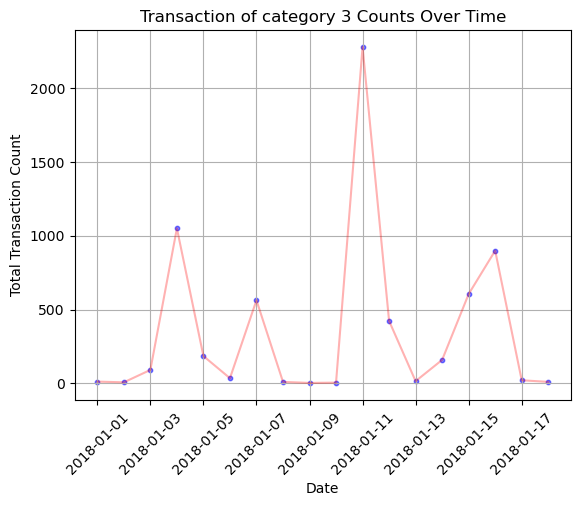

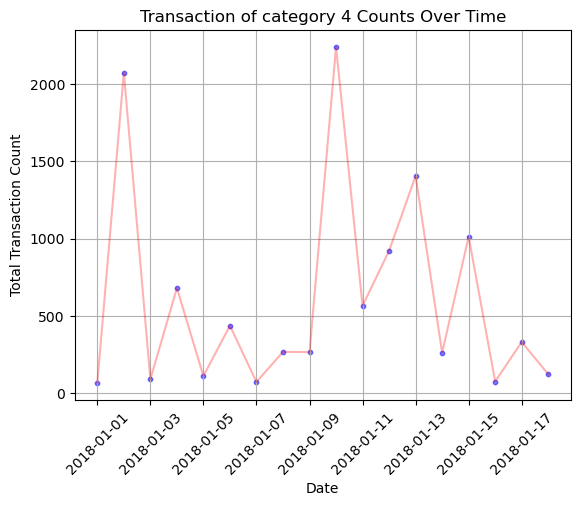

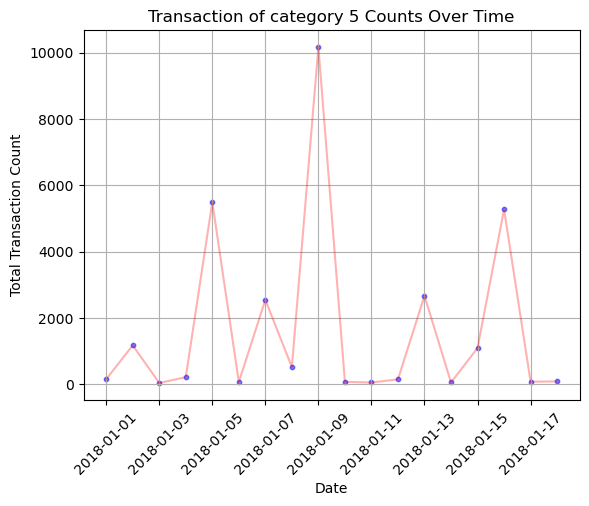

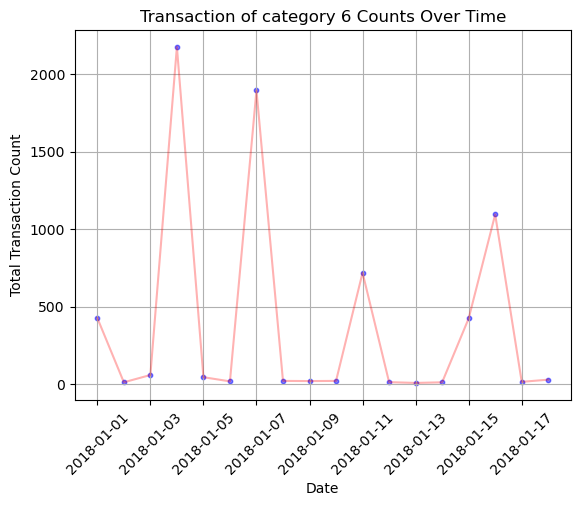

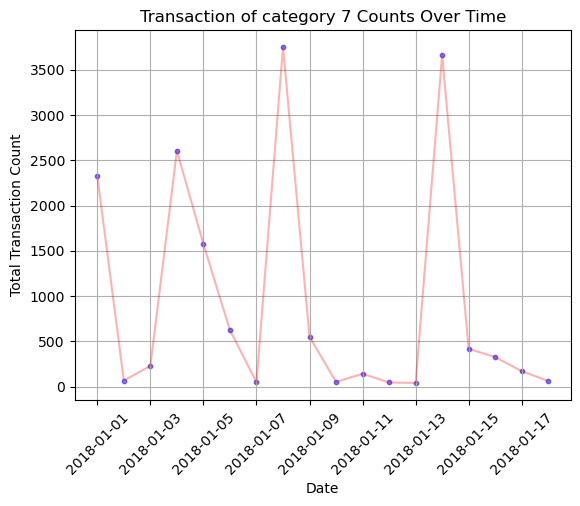

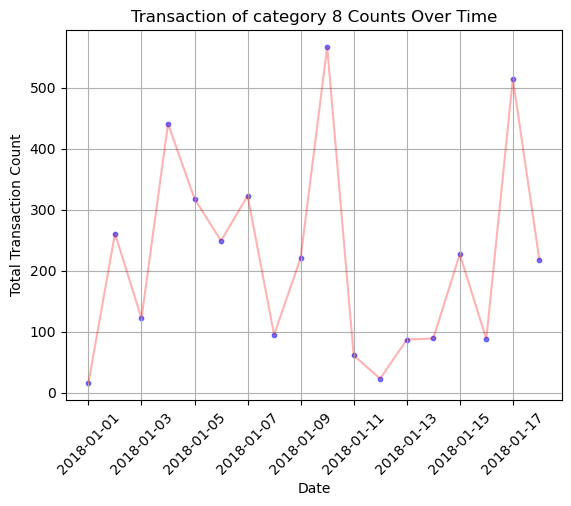

In [116]:
# Plot of the aggregated sales of the different groups inside 'categorie1' 

category1_totals = daily_ordersID.groupby(['date','category1'])['transactionCount'].sum().reset_index()


for category in range(1, len(category1_totals['category1'].unique())+1):
    n_category = category1_totals[category1_totals['category1'] == str(category)]
    plt.scatter(n_category['date'], n_category['transactionCount'], s=10, color='blue', alpha=0.5)
    plt.plot(n_category['date'], n_category['transactionCount'], color='red', alpha=0.3)
    plt.title(f'Transaction of category {category} Counts Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Transaction Count')
    plt.grid(True)
    plt.xticks(rotation = 45)
    plt.show()


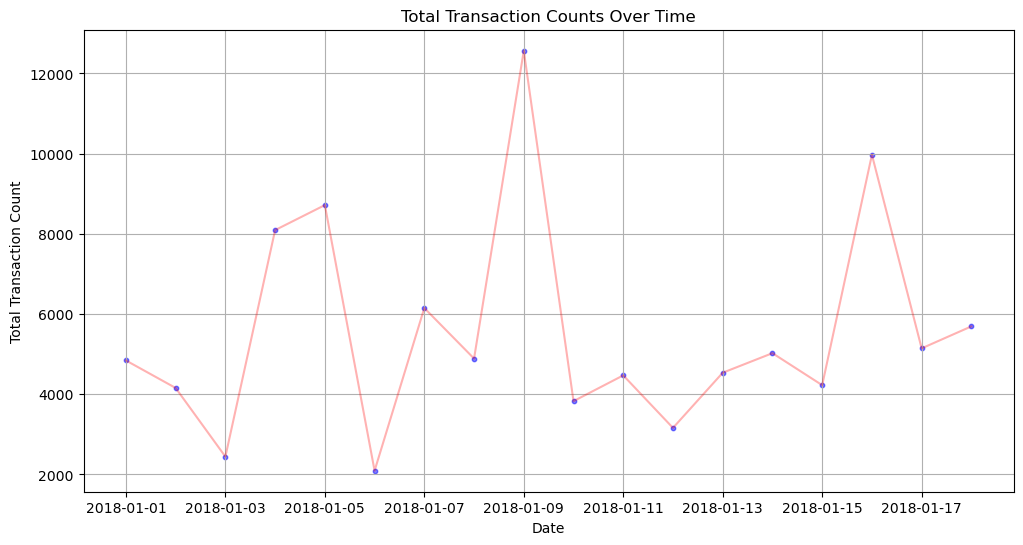

In [94]:
# Create a scatter plot to visualize the total transaction count over time

daily_totals = daily_ordersID.groupby('date')['transactionCount'].sum().reset_index()

plt.figure(figsize=(12, 6))  # Set the figure size
plt.scatter(daily_totals['date'], daily_totals['transactionCount'], s=10, color='blue', alpha=0.5)
plt.plot(daily_totals['date'], daily_totals['transactionCount'], color='red', alpha=0.3)
plt.title('Total Transaction Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Total Transaction Count')
plt.grid(True)
plt.show()

In [71]:
# Average of the number of items per day per item

itemID_means = daily_ordersID.groupby('itemID')['itemsSold'].mean().reset_index()
itemID_means

,itemID,itemsSold
0,10000,50.50
1,105,1.50
2,106,1.00
3,109,2.00
4,11,1.50
...,...,...
1840,9887,12.00
1841,99,1.00
1842,9938,20.00
1843,9986,1.00


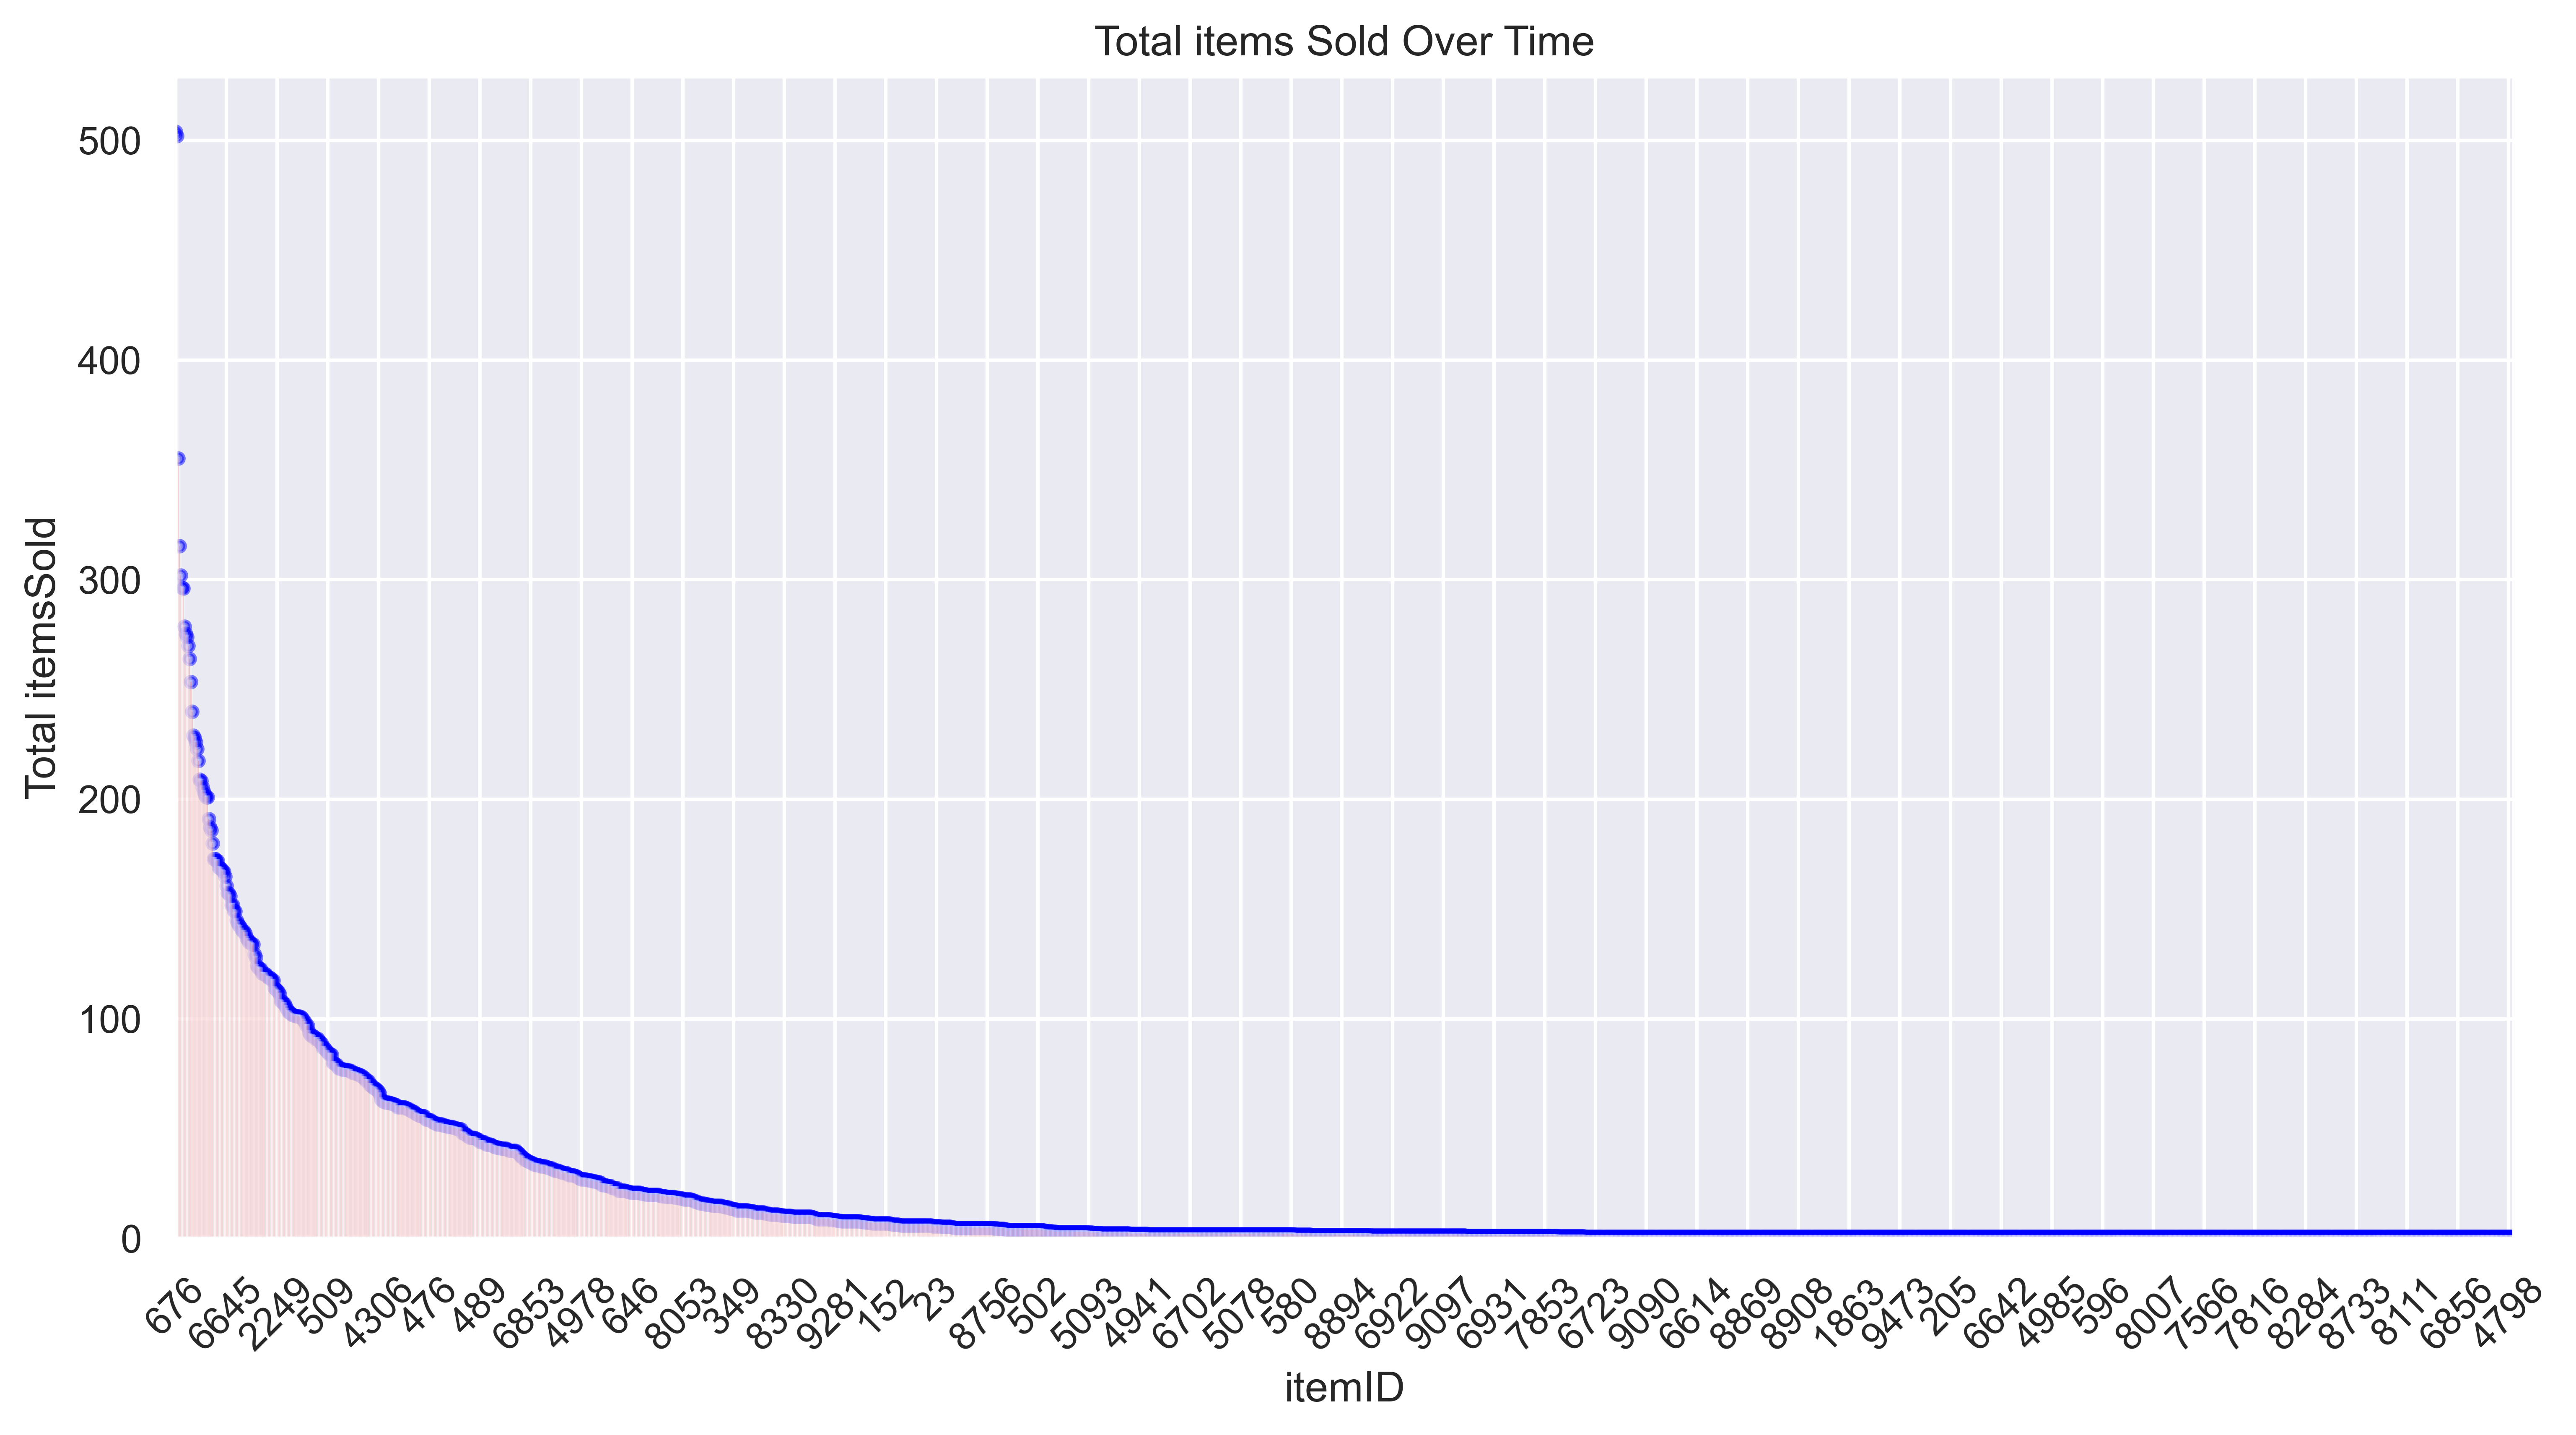

In [15]:
# Plot of the average number of items purchased per day per item 


itemID_means = daily_ordersID.groupby('itemID')['itemsSold'].mean().reset_index()
#itemID_means['itemID'] = itemID_means['itemID'].astype(int)
itemID_means = itemID_means.sort_values('itemsSold', ascending = False)


plt.figure(figsize=(12, 6))  # Set the figure size
plt.scatter(itemID_means['itemID'], itemID_means['itemsSold'], s=10, color='blue', alpha=0.5)
sns.barplot(itemID_means['itemID'], itemID_means['itemsSold'], color='red', alpha=0.3)
plt.title('Total items Sold Over Time')
plt.xlabel('itemID')
plt.ylabel('Total itemsSold')
plt.xticks(itemID_means['itemID'][::40], rotation = 45)
plt.grid(True)
sns.set(rc={"figure.dpi":600})
plt.show()

In [84]:
# Check basic information about the features that will be use in the forecasting process


for col in daily_ordersID.columns:
    
    print(daily_ordersID[col].describe())
    print('-----------------------------')

count     5044
unique    1845
top       7798
freq        18
Name: itemID, dtype: object
-----------------------------
count    5044.000000
mean       25.693299
std       121.836376
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max      2719.000000
Name: itemsSold, dtype: float64
-----------------------------
count     5044
unique     102
top          0
freq      2758
Name: brand, dtype: object
-----------------------------
count     5044
unique     145
top        121
freq       370
Name: manufacturer, dtype: object
-----------------------------
count     5044
unique      85
top        0.0
freq      1638
Name: customerRating, dtype: object
-----------------------------
count     5044
unique       8
top          4
freq      1192
Name: category1, dtype: object
-----------------------------
count     5044
unique      48
top         23
freq       515
Name: category2, dtype: object
-----------------------------
count     5044
unique       8
top          

In [137]:
# Number of times a unique item has been purchased during the time covered by the dataset 
#  (e.g., 435 unique items have been sold one time during the 18 days)

daily_ordersID.groupby('itemID')['itemsSold'].sum().value_counts()

1       435
2       271
3       132
4       103
5        84
       ... 
1385      1
862       1
537       1
534       1
81        1
Name: itemsSold, Length: 290, dtype: int64

In [92]:
# Total sells for the most common frequency items have been sold

(daily_ordersID.groupby('itemID')['itemsSold'].sum().value_counts()[:1]/daily_ordersID['itemsSold'].sum())*100

1    0.335656
Name: itemsSold, dtype: float64

Text(0.5, 1.0, 'Top 5 frequencies items have been sold')

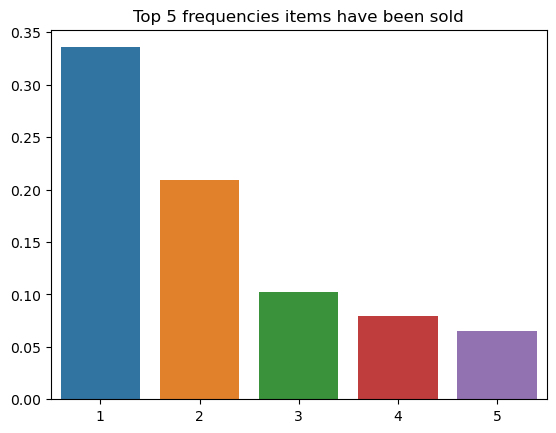

In [12]:
# The top 5 frequencies an item has been sold in the dataset

percentages  = [i * 100 for i in daily_ordersID.groupby('itemID')['itemsSold'].sum().value_counts()/daily_ordersID['itemsSold'].sum()]

sns.barplot(daily_ordersID.groupby('itemID')['itemsSold'].sum().value_counts().index[:5],  percentages[:5])
plt.title('Top 5 frequencies items have been sold')

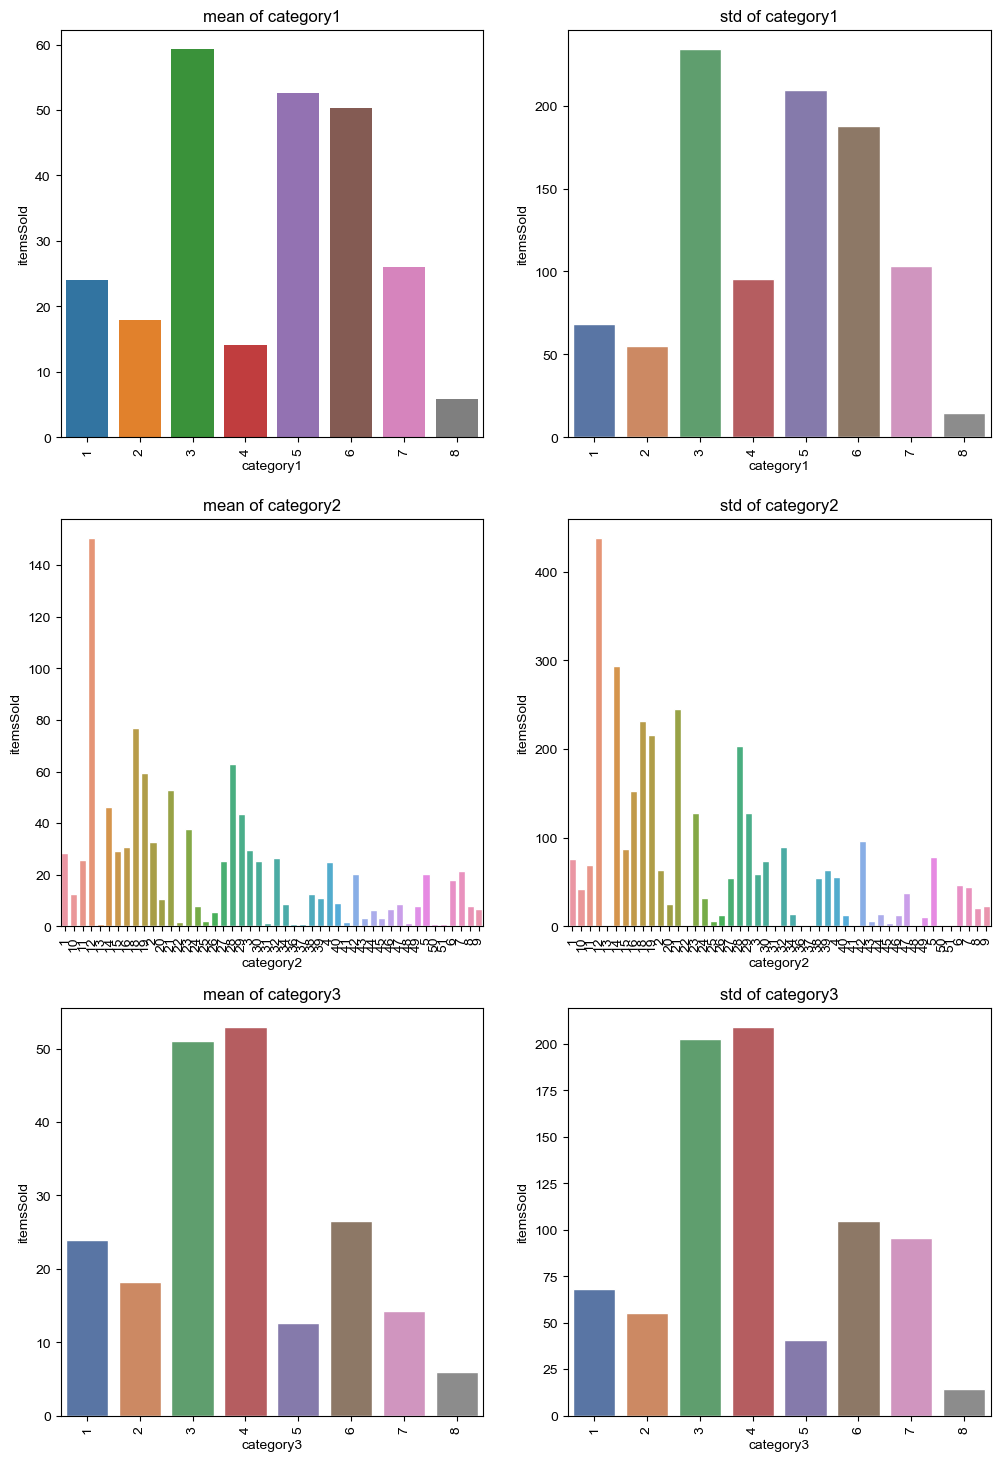

In [14]:
# Mean and std of the items sold of the different groups in the three features (category1 to 3) in the whole dataset 


grouped_columns = ['category1', 'category2',  'category3', ]

fig, axes = plt.subplots(nrows = len(grouped_columns), ncols = 2, figsize = (12, 6 * len(grouped_columns)))


for col, ax in zip(grouped_columns, axes):
    
    itemID_category_means = daily_ordersID.groupby(col)['itemsSold'].mean().reset_index()
    itemID_category_std = daily_ordersID.groupby(col)['itemsSold'].std().reset_index()
    
    sns.barplot(itemID_category_means[col], itemID_category_means['itemsSold'], ax = ax[0])
    ax[0].set_title(f'mean of {col}')
    ax[0].xaxis.set_tick_params(rotation = 90)
    sns.set(rc={"figure.dpi":600})


    
    sns.barplot(itemID_category_std[col], itemID_category_std['itemsSold'], ax = ax[1])
    ax[1].set_title(f'std of {col}')
    ax[1].xaxis.set_tick_params(rotation = 90)
    sns.set(rc={"figure.dpi":600})


    